In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import dwave_networkx as dnx
import pandas as pd
import numpy as np
import json
from scipy.optimize import curve_fit
from music21 import stream, converter, instrument, tinyNotation, environment
#us = environment.UserSettings()
#us['musicxmlPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'
#us['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 4\\bin\\MuseScore4.exe'

from colours import Tableau as T
from LBDM import calculateStrengths
from plots import plotBoundaryStrength, plotLagrange, plotHistogram, plotEnergyGaps
from qubo import createBQM

plt.style.use("thesis.mplstyle")

picklePath = lambda id : f"../Pickles/{id}/{id}_"
numberPath = lambda id, num : f"../Pickles/{id}/{num}/{id}_{num}_"
dataPath = lambda id, num : f"../Data/{id}/{num}/{id}_{num}_"
figPath = "../Figures/"

### Histogram

155.90876276788083 8.765143803370254


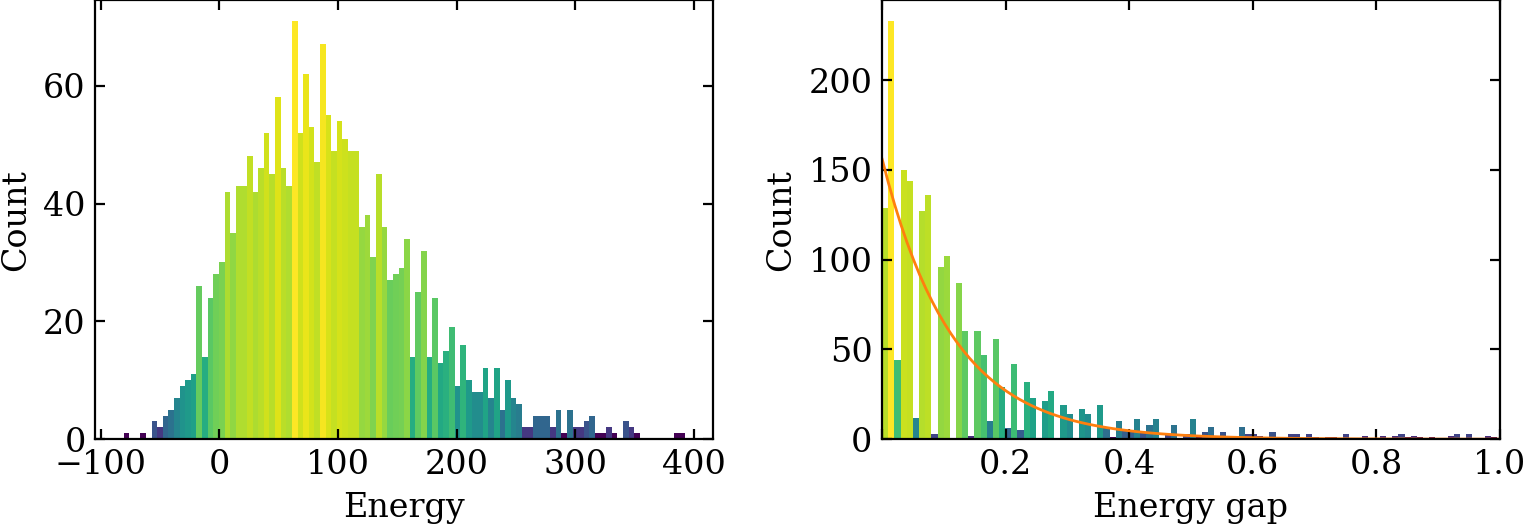

In [22]:
df = pd.read_csv(dataPath("beethoven-op67", 3) + "sampleset.csv")

def plotHistogram(sampleset: pd.DataFrame) -> None:
    '''
    Plots the histogram of a sampleset.
    '''

    N, _, patches = plt.hist(sampleset["energy"], bins=100)

    norm = mpl.colors.LogNorm(1, N.max())
    for thisfrac, thispatch in zip(N, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    plt.xlabel("Energy")
    plt.ylabel("Count")

plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plotHistogram(df)

def plotEnergyGaps(df: pd.DataFrame) -> None:   

    sorted = df.sort_values("energy")
    gaps = [sorted["energy"].iloc[i+1] - sorted["energy"].iloc[i] for i in range(len(sorted)-1)]

    gaps = [g for g in gaps if g <= 1]

    N, _, patches = plt.hist(gaps, bins=100)

    norm = mpl.colors.LogNorm(1, N.max())
    for thisfrac, thispatch in zip(N, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    f = lambda x,A,t: A * np.exp(-t*x)
    r = np.linspace(0,1,100)
    (A, t), _ = curve_fit(f, r, N)

    print(A, t)
    plt.plot(r, f(r, A, t), ms=0)
    
    plt.xlim(0,1)

    labels = plt.gca().get_xticklabels()
    labels[0].set_visible(False)

    plt.xlabel("Energy gap")
    plt.ylabel("Count")

plt.subplot(1, 2, 2)
plotEnergyGaps(df)

plt.tight_layout()
#plt.savefig(figPath+"haydn-histograms.svg")

### Phrase extraction

In [ ]:
phrases = pd.read_csv(picklePath("haydn-op1") + "phrases.csv", index_col=[0,1])
print(len(phrases))

phrases = pd.read_csv(picklePath("beethoven-op67") + "phrases.csv", index_col=[0,1])
print(len(phrases))

192
127


In [ ]:
score = converter.parse(picklePath("haydn-op1") + "score.musicxml")
part = score.parts[0]
df = calculateStrengths(part, 0.3, (0.33, 0.66))

print(len(df.query("IsBoundary")))

plt.figure(1, figsize=(8,3))
plotBoundaryStrength(df, 0.3)
plt.savefig("../Figures/haydn-lbdm.svg")

score = converter.parse(picklePath("beethoven-op67") + "score.musicxml")
part = score.parts[7]
df = calculateStrengths(part, 0.25, (0.33, 0.66))

plt.figure(2)
plotBoundaryStrength(df, 0.25)
plt.savefig("../Figures/beethoven-lbdm.svg")

NameError: name 'converter' is not defined

### Lagrange parameters

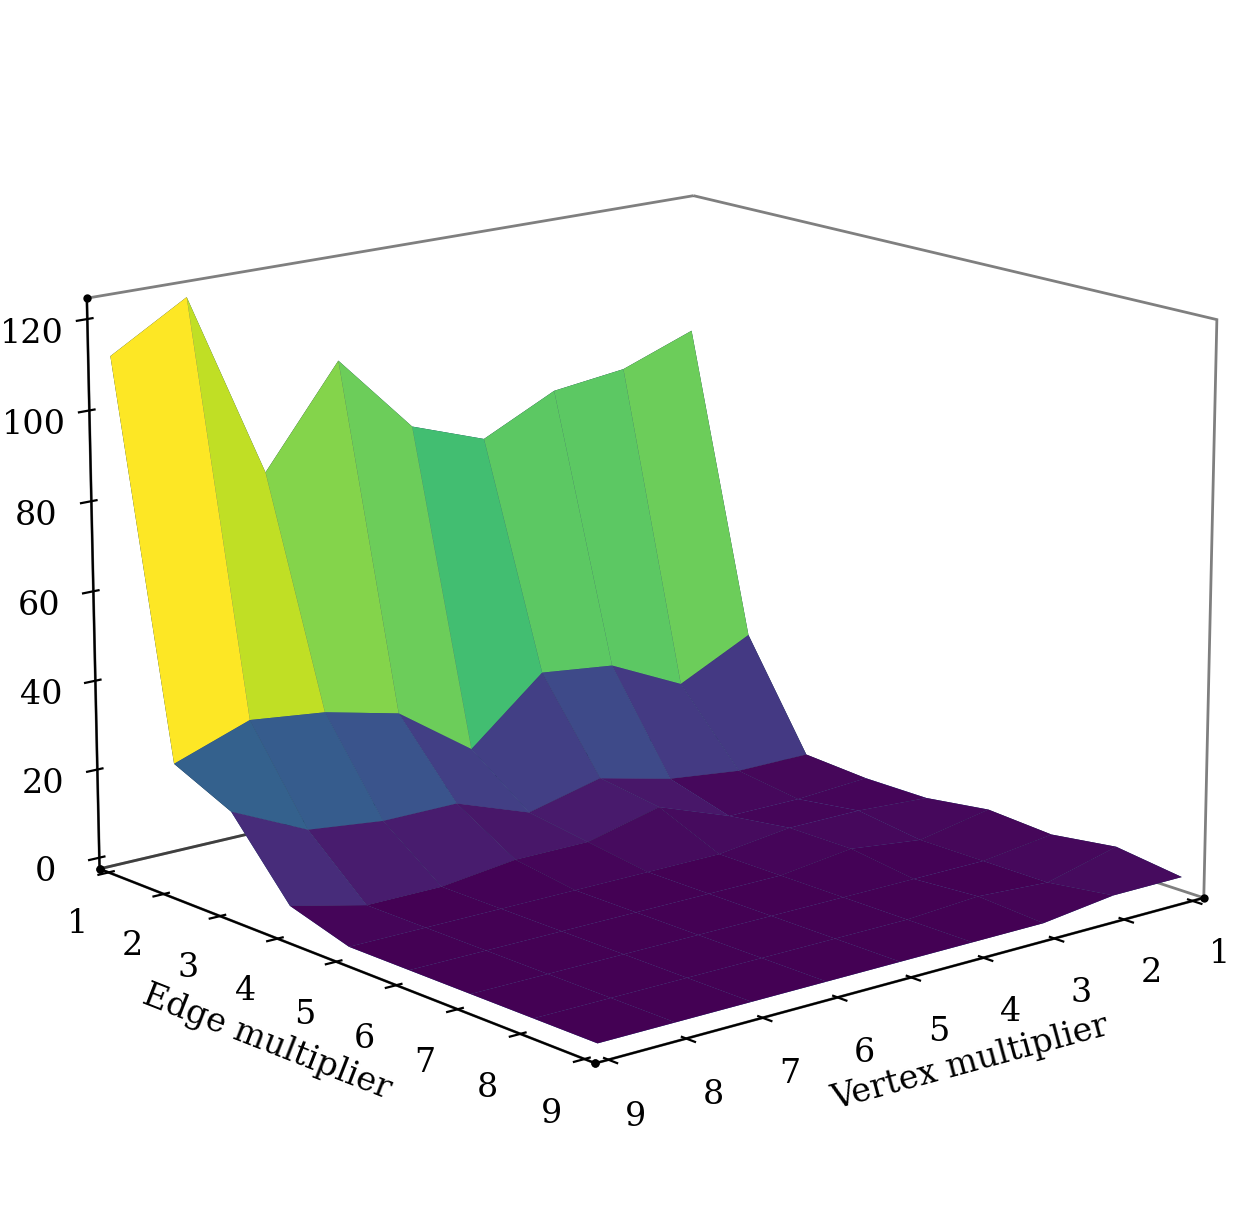

In [ ]:
data = pd.read_csv(dataPath("haydn-op1", 2) + "lagrange.csv")

plotLagrange(data)
#plt.savefig("../Figures/haydn-lagrange.svg")

### Solver configuration

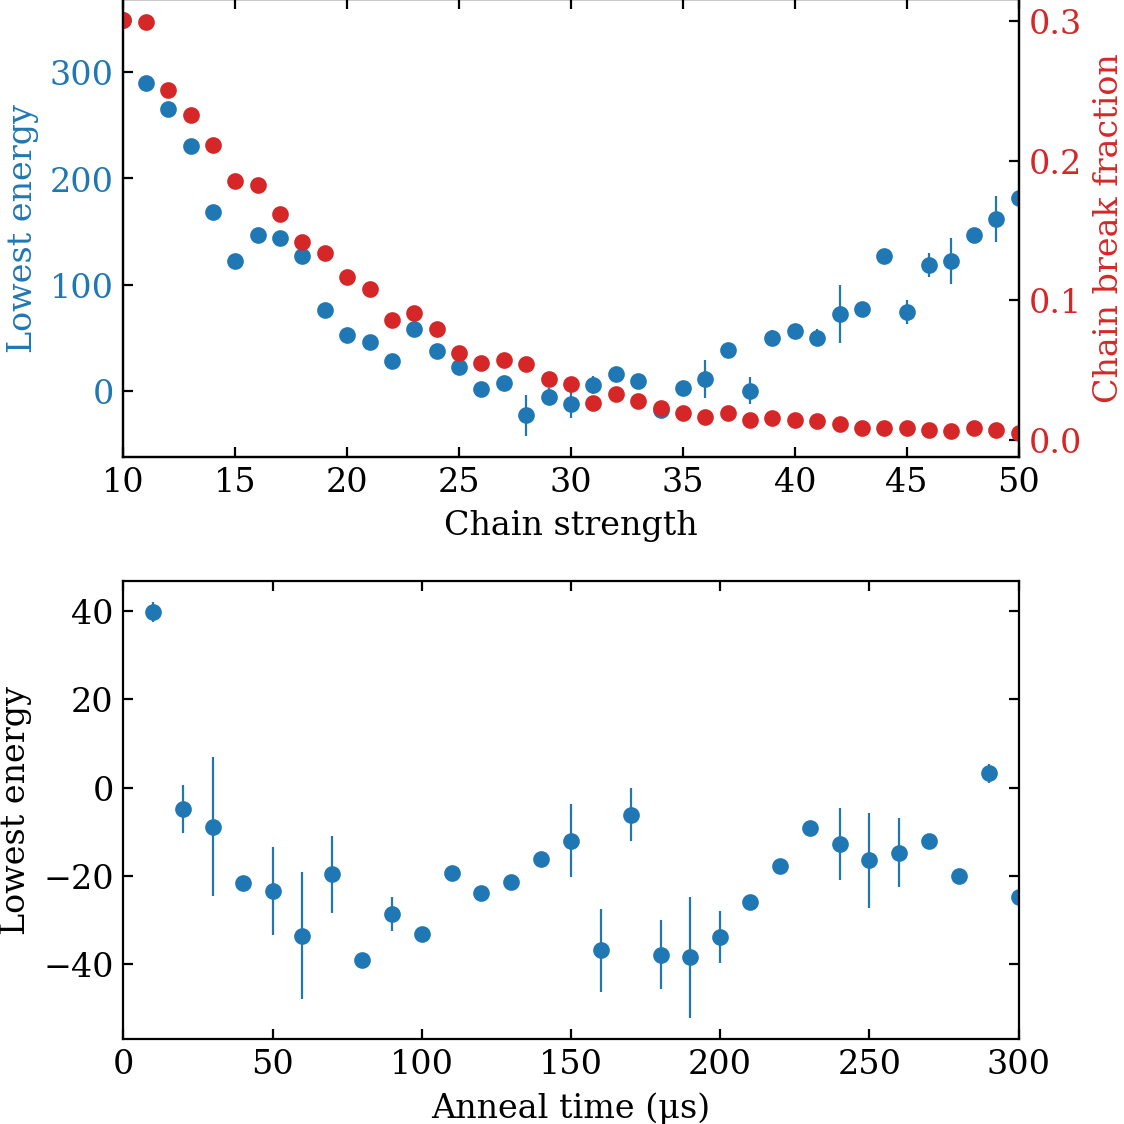

In [79]:
def plotChainStrengthAndAnnealTime(id: str, num: int):

    data = pd.read_csv(dataPath(id, num) + "chain-strength.csv")

    #plotCSV(dataPath("haydn-op1", 3) + "chain-strength.csv", "Chain strength", "Chain break fraction")
    #plotCSV(dataPath("haydn-op1", 3) + "chain-strength.csv", "Chain strength", "Lowest energy")

    def meanAndStderr(df: pd.DataFrame, xaxis: str, yaxis: str):
        x = df[xaxis].unique()
        queries = [data.query(f"`{xaxis}` == {i}")[yaxis] for i in x]

        mean = np.array([np.mean(q) for q in queries])
        stderr = np.array([np.std(q)/np.sqrt(len(q)) for q in queries])

        return x, mean, stderr

    fig, (ax1, ax3) = plt.subplots(nrows=2, figsize=(6,6))

    # Chain strength

    # Lowest energy
    x, mean, stderr = meanAndStderr(data, "Chain strength", "Lowest energy")
    color = 'tab:blue'
    ax1.set_xlabel("Chain strength")
    ax1.set_ylabel("Lowest energy", color=color)
    ax1.errorbar(x, mean, yerr=stderr, fmt='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xlim(10,50)

    ax2 = ax1.twinx()
    #x, dupl, stderr = meanAndStderr(data, "Chain strength", "Duplicates")
    #x, ovlp, stderr = meanAndStderr(data, "Chain strength", "Overlaps")
    #mean = dupl + ovlp
    # Chain break fraction
    x, mean, stderr = meanAndStderr(data, "Chain strength", "Chain break fraction")
    color = 'tab:red'
    ax2.set_ylabel("Chain break fraction", color=color)
    ax2.errorbar(x, mean, yerr=stderr, fmt='o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Anneal time

    data = pd.read_csv(dataPath(id, num) + "anneal-time.csv")

    x, mean, stderr = meanAndStderr(data, "Anneal time", "Lowest energy")
    ax3.errorbar(x, mean, yerr=stderr, fmt='o', color='tab:blue')
    ax3.set(xlabel="Anneal time (μs)", ylabel="Lowest energy", xlim=(0,300))
    
    fig.tight_layout()

plotChainStrengthAndAnnealTime("beethoven-op67", 4)

#plt.savefig("../Figures/beethoven-solver-config.svg")

(0.53, 0.61)

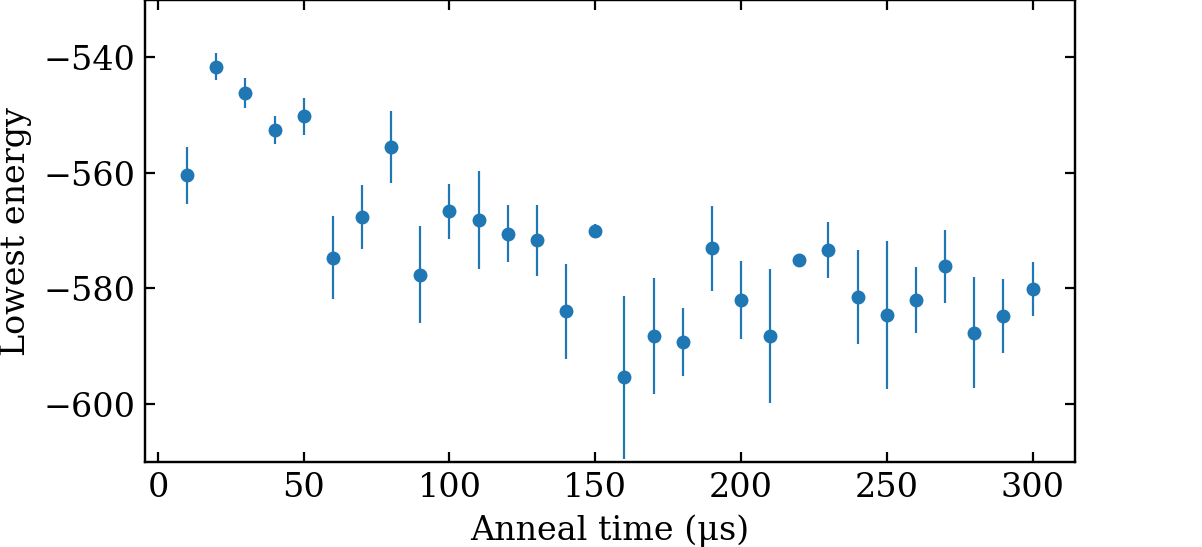

In [ ]:


fig, ax1 = plt.subplots(figsize=(6,3))



#plt.savefig("../Figures/haydn-anneal-time.svg")

### Compare to classical

[-3.21697067e-02 -5.80254455e+02]
[-3.89539607e-03 -4.69830176e+02]
[-1.57637081e-02 -5.93457645e+02]
Haydn Op. 1 would show supremacy at 804.7781934804296 reads
[-1.14021592e-02 -4.24722287e+01]
[-3.64294209e-03 -1.12329472e+02]
[-2.91462818e-03 -1.24391564e+02]
Beethoven Op. 67 would show supremacy at 9651.727338702374 reads
[3.04898375e-03 1.50419478e+02]
[-1.57985229e-03  1.41967809e+02]
[1.26869603e-04 1.46145862e+02]
Haydn Op. 1 would show supremacy at -1462.5082407350988 reads
[3.11482325e-04 9.52616181e+00]
[2.72193674e-04 1.39689462e+01]
[4.03789540e-04 1.57129554e+01]
Beethoven Op. 67 would show supremacy at -67023.94276038183 reads


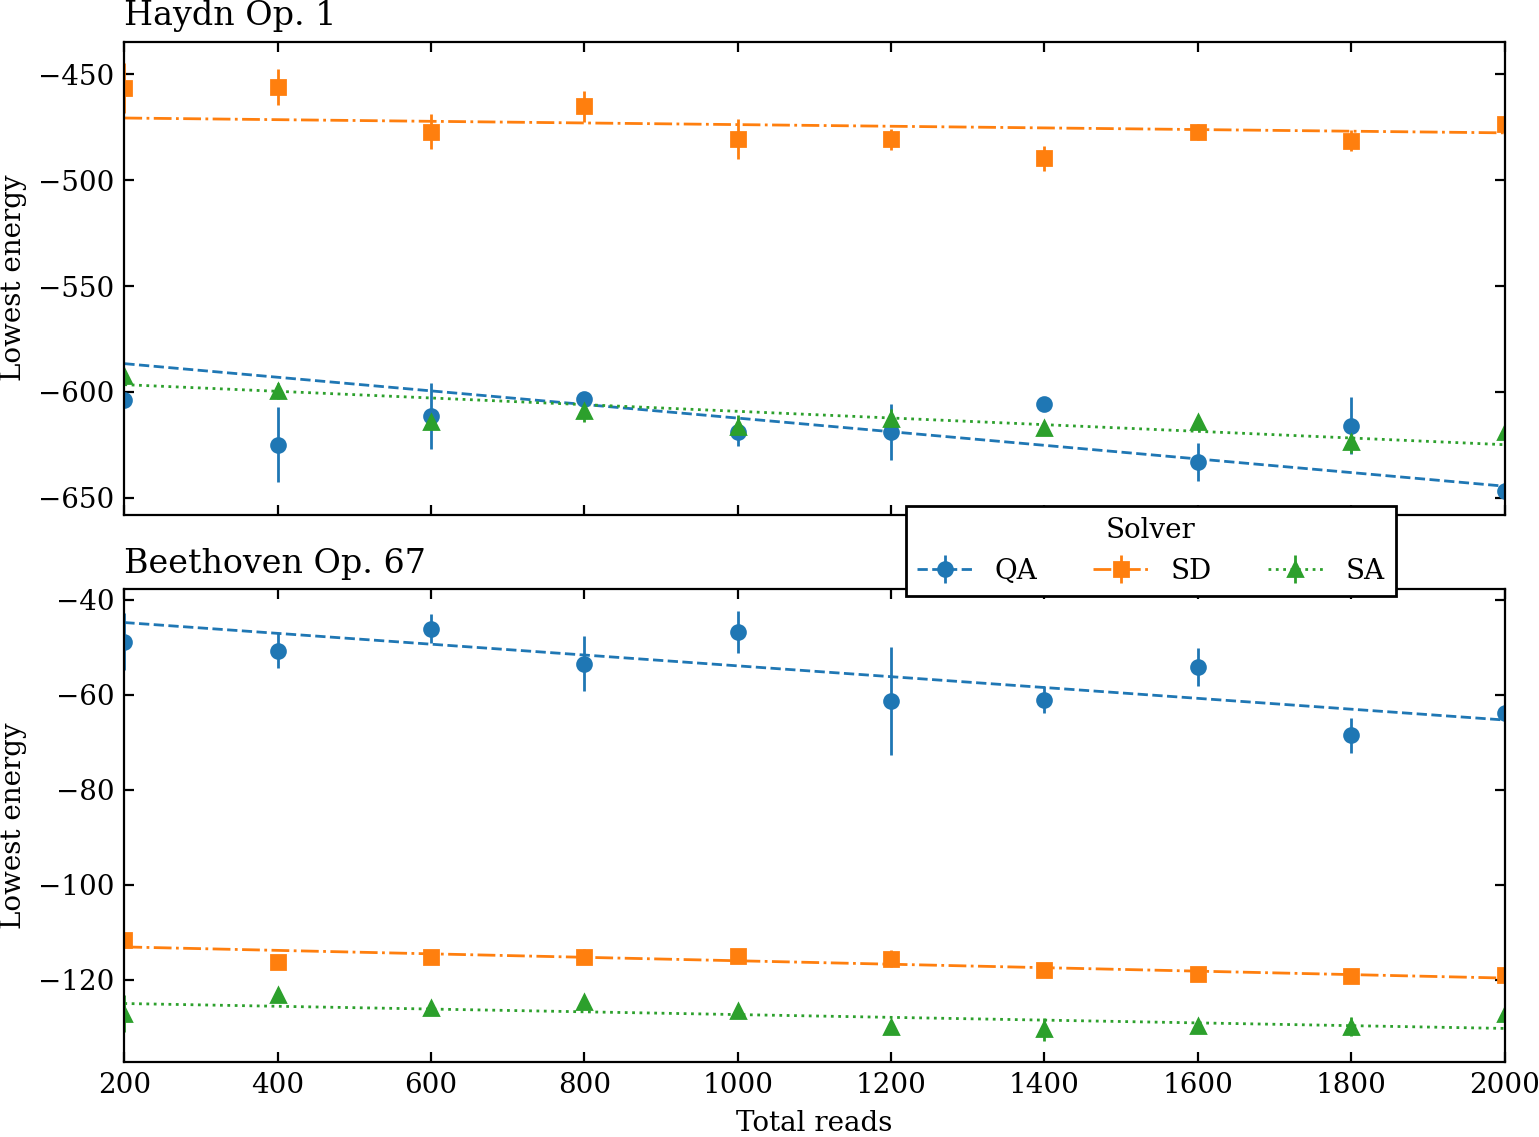

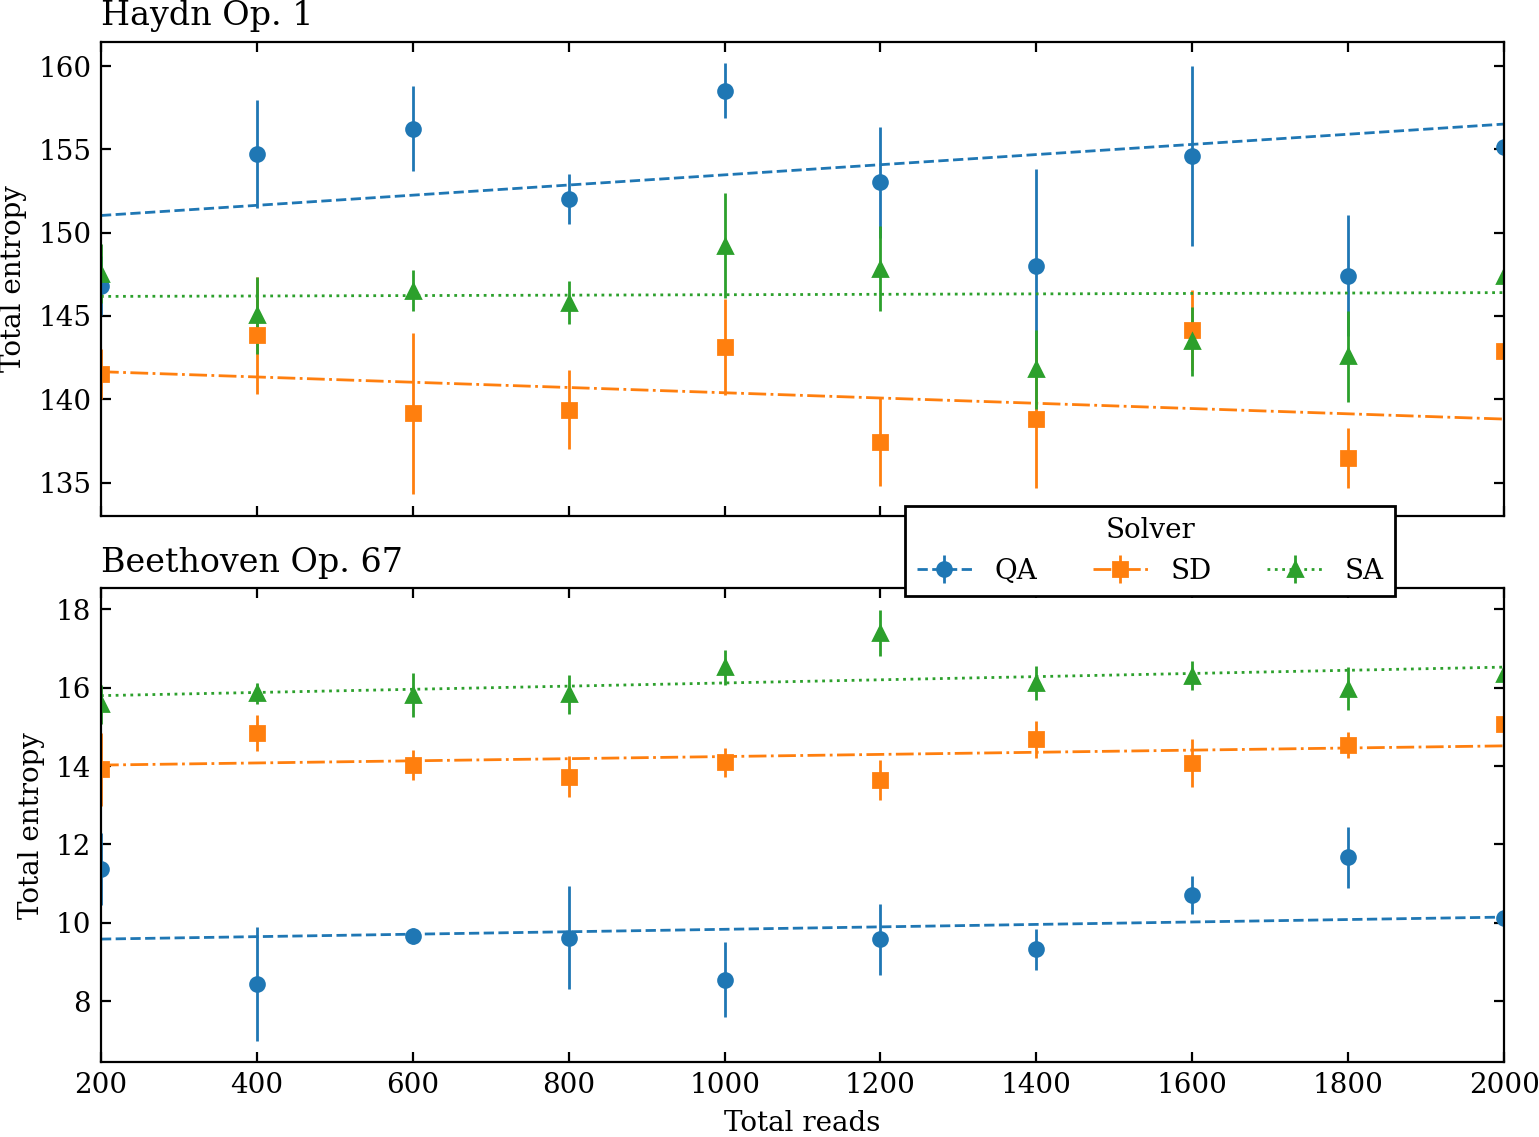

In [38]:
def plotCSV(filepath: str, xaxis: str, yaxis: str, axis, colour: str = "tab:blue", label: str = "", marker: str = "o", ls: str = "--") -> None:

    data = pd.read_csv(filepath)
    x = data[xaxis].unique()

    means = []
    stderr = []

    for r in x:
        query = data.query(f"`{xaxis}` == {r}")[yaxis]
        means.append(np.mean(query))
        stderr.append(np.std(query)/np.sqrt(len(query)))

    f = lambda x,m,c: m*x + c
    popt, _ = curve_fit(f, x, means, sigma=stderr)
    print(popt)
    axis.errorbar(x, means, yerr=stderr, fmt=marker, label=label, c=colour)
    axis.plot(x, f(x,popt[0],popt[1]), ls=ls, c=colour, ms=0, label=label)

    return popt[0], popt[1]


def plotCompareClassical(yaxis: str):

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8,6))

    fp = dataPath("haydn-op1",3)
    m1, c1 = plotCSV(fp+"qa-reads.csv", "Total reads", yaxis, ax1, "tab:blue", "QA", "o", "--")
    plotCSV(fp+"sd-reads.csv", "Total reads", yaxis, ax1, "tab:orange", "SD", "s", "-.")
    m2, c2 = plotCSV(fp+"sa-reads.csv", "Total reads", yaxis, ax1, "tab:green", "SA", "^", ":")
    ax1.set(ylabel=yaxis)
    ax1.set_title("Haydn Op. 1", loc="left")

    print(f"Haydn Op. 1 would show supremacy at {(c2-c1)/(m1-m2)} reads")

    fp = dataPath("beethoven-op67",3)
    m1, c1 = plotCSV(fp+"qa-reads.csv", "Total reads", yaxis, ax2, "tab:blue", "QA", "o", "--")
    plotCSV(fp+"sd-reads.csv", "Total reads", yaxis, ax2, "tab:orange", "SD", "s", "-.")
    m2, c2 = plotCSV(fp+"sa-reads.csv", "Total reads", yaxis, ax2, "tab:green", "SA", "^", ":")
    ax2.set(xlabel="Total reads", ylabel=yaxis, xlim=(200,2000))
    ax2.set_title("Beethoven Op. 67", loc="left")

    print(f"Beethoven Op. 67 would show supremacy at {(c2-c1)/(m1-m2)} reads")

    lines, labels = ax1.get_legend_handles_labels()

    # Finally, the legend (that maybe you'll customize differently)
    fig.legend(zip(lines[:3],lines[3:]), labels[:3], title="Solver",
               loc="center right", ncols=3, bbox_to_anchor=(.9, 0.515))
    fig.tight_layout()

    return fig

plotCompareClassical("Lowest energy").savefig("../Figures/compare-reads.svg")
plotCompareClassical("Total entropy").savefig("../Figures/compare-entropy.svg")


### Scaling

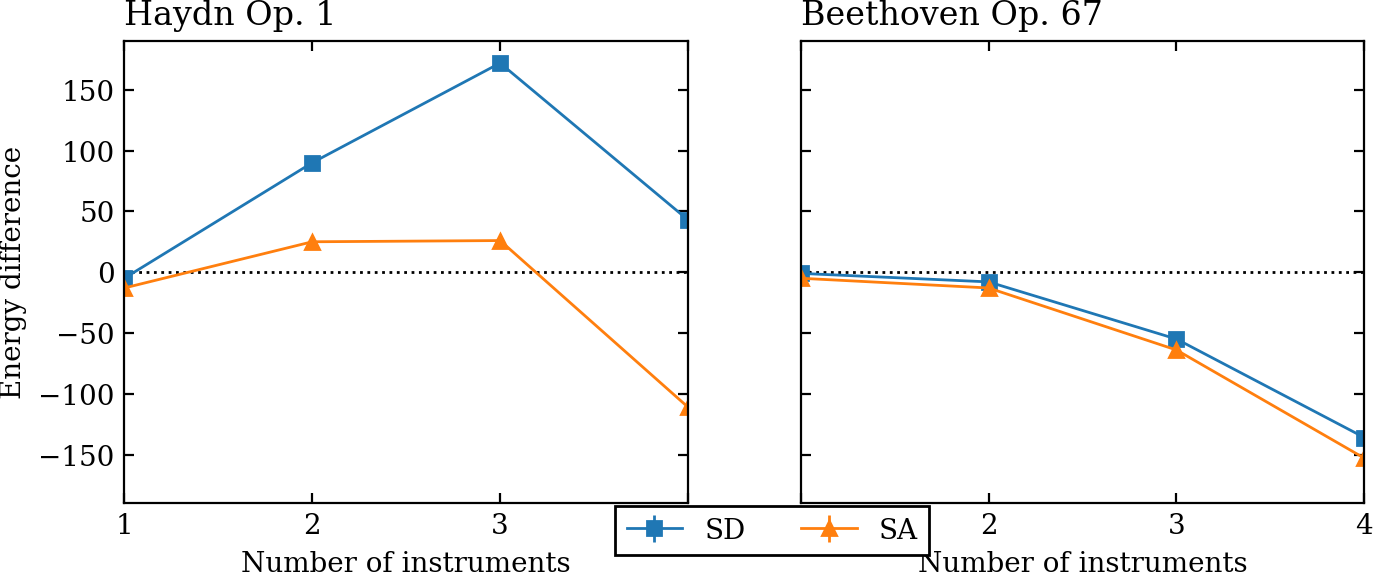

In [83]:
def plotCompareScaling(id: str, insts: int, yaxis: str, reads: int, ax, scale: float = 1) -> None:

    instRange = np.arange(insts)

    qa = np.empty_like(instRange)
    qaerr = np.empty_like(instRange)
    sd = np.empty_like(instRange)
    sderr = np.empty_like(instRange)
    sa = np.empty_like(instRange)
    saerr = np.empty_like(instRange)

    for i in instRange:

        fp = dataPath(id, i+1)
        data = pd.read_csv(fp+"qa-reads.csv")
        query = data.query(f"`Total reads` == {reads}")[yaxis]
        qa[i] = np.mean(query)
        qaerr[i] = np.std(query)/np.sqrt(len(query))

        data = pd.read_csv(fp+"sd-reads.csv")
        query = data.query(f"`Total reads` == {reads}")[yaxis]
        sd[i] = np.mean(query) - qa[i]
        sderr[i] = np.std(query)/np.sqrt(len(query))

        data = pd.read_csv(fp+"sa-reads.csv")
        query = data.query(f"`Total reads` == {reads}")[yaxis]
        sa[i] = np.mean(query) - qa[i]
        saerr[i] = np.std(query)/np.sqrt(len(query))

    #plt.errorbar(insts+1, qa, yerr=qaerr, label="QA", marker="o")
    ax.errorbar(instRange+1, sd*scale, yerr=sderr*scale, label="SD", marker="s")
    ax.errorbar(instRange+1, sa*scale, yerr=saerr*scale, label="SA", marker="^")
    ax.hlines(0, 1, 4, linestyles=":", colors="black")
    ax.set(xlabel="Number of instruments", xlim=(1,4), xticks=instRange+1)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8,3))
ax1.set(ylabel="Energy difference", ylim=(-190,190), yticks=range(-150,200,50))

plotCompareScaling("haydn-op1", 4, "Lowest energy", 2000, ax1)
plotCompareScaling("beethoven-op67", 4, "Lowest energy", 2000, ax2)

ax1.set_title("Haydn Op. 1", loc="left")
ax2.set_title("Beethoven Op. 67", loc="left")

lines, labels = ax1.get_legend_handles_labels()

fig.legend(lines, labels, loc="lower center", ncols=2, bbox_to_anchor=(.53, 0))
#fig.tight_layout()

plt.savefig("../Figures/scaling-energy.svg")

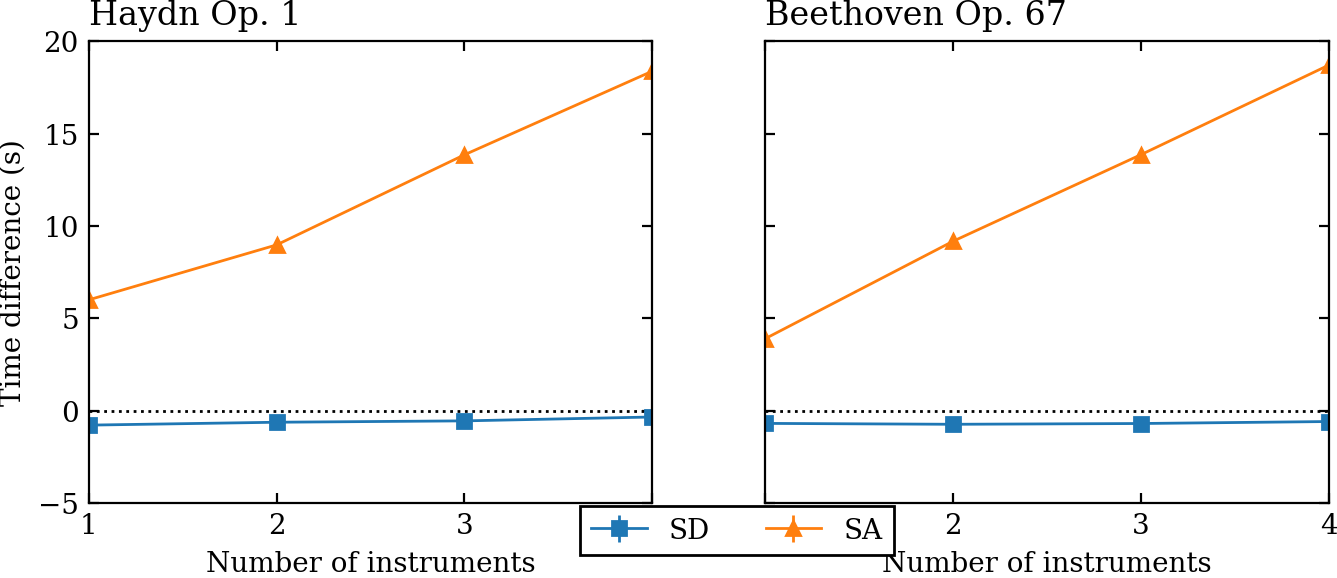

In [81]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(8,3))
ax1.set(ylabel="Time difference (s)", ylim=(-5,20))

plotCompareScaling("haydn-op1", 4, "Time", 2000, ax1, scale=1e-6)
plotCompareScaling("beethoven-op67", 4, "Time", 2000, ax2, scale=1e-6)

ax1.set_title("Haydn Op. 1", loc="left")
ax2.set_title("Beethoven Op. 67", loc="left")

lines, labels = ax1.get_legend_handles_labels()

fig.legend(lines, labels, loc="lower center", ncols=2, bbox_to_anchor=(.53, 0))
#fig.tight_layout()

plt.savefig("../Figures/scaling-time.svg")

### Embedding

95.25000235717441 545.449985618336 -383.74998049934936
151.24999978633238 381.2500006054849 -219.24999937510324


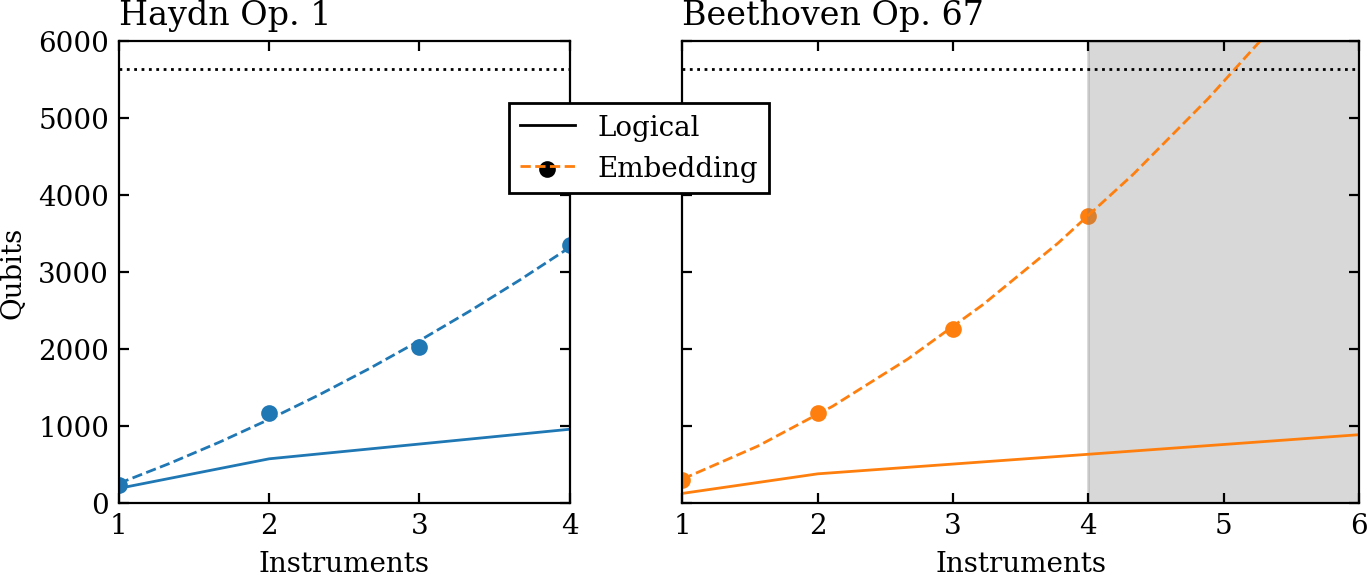

In [18]:
def plotEmbedding(id: str, insts: int, ax, colour: str, marker: str, title: str, extend = 0):

    phrases = pd.read_csv(picklePath(id) + "phrases.csv", index_col=[0,1])

    embedRange = np.arange(insts) + 1
    instRange = np.arange(insts + extend) + 1
    bqms = np.array([len(phrases)*(i+1) for i in instRange])
    bqms[0] = len(phrases)

    ax.set(xlabel="Instruments", xlim=(instRange[0], instRange[-1]), xticks=instRange, ylim=(0,6000))
    ax.plot(instRange, bqms, c=colour, ms=0, label="Logical")
    ax.set_title(title, loc="left")

    embeddings = np.empty(insts)
    
    for i in embedRange:
        embedding = json.load(open(numberPath(id, i) + "embedding.json"))
        embeddings[i-1] = sum(len(j) for j in embedding.values())

    ax.scatter(embedRange, embeddings, c=colour, marker=marker, label="Embedding")
    ax.hlines(5640, 1, insts+extend, linestyles=":", colors="k")
    
    if extend != 0:
        ax.axvspan(insts, insts+extend, color="gray", alpha=.3)

    f = lambda x,a,b,c: a*x**2 + b*x + c
    (a, b, c), _ = curve_fit(f, embedRange, embeddings)
    print(a,b,c)

    r = np.linspace(1,instRange[-1],10)
    ax.plot(r, f(r, a, b, c), ms=0, color=colour, ls="--", label="Projected")

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(8,3), width_ratios=(4,6))
ax1.set(ylabel="Qubits")

plotEmbedding("haydn-op1", 4, ax1, "tab:blue", "o", "Haydn Op. 1")
plotEmbedding("beethoven-op67", 4, ax2, "tab:orange", "o", "Beethoven Op. 67", extend=2)

lines, labels = plt.gca().get_legend_handles_labels()

leg = fig.legend([lines[0],(lines[1],lines[2])], [labels[0],labels[1]],
                 loc="upper center", bbox_to_anchor=(0.45,.8))

for l in leg.legend_handles: l.set_color('k')
#fig.tight_layout()

plt.savefig(figPath+"embedding.svg")

### Pegasus architecture

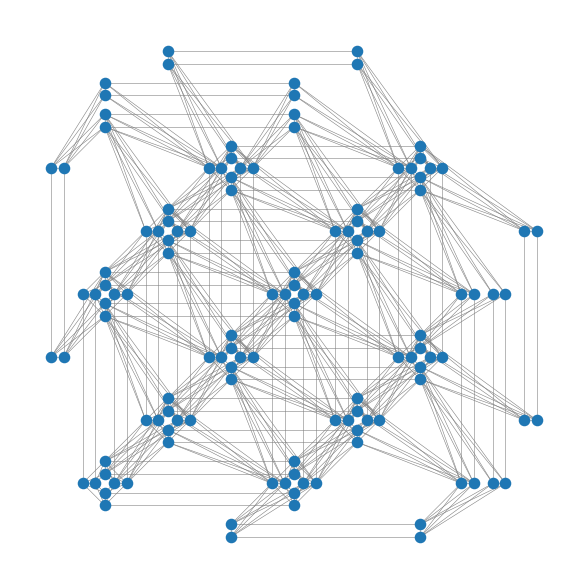

In [17]:
P = dnx.pegasus_graph(3)
#fig, ax = plt.subplots(layout="constrained")
dnx.draw_pegasus(P, with_labels=False, node_size = 10, width=0.2, crosses=True, node_color="tab:blue", edge_color="gray")
plt.gca().set_aspect('equal')
plt.savefig("..\Figures\pegasus.svg")

### Toy score

In [ ]:
class ColorModifier(tinyNotation.Modifier):
    def postParse(self, m21Obj):
        m21Obj.style.color = self.modifierData
        return m21Obj

tnc = tinyNotation.Converter()
tnc.modifierAngle = ColorModifier

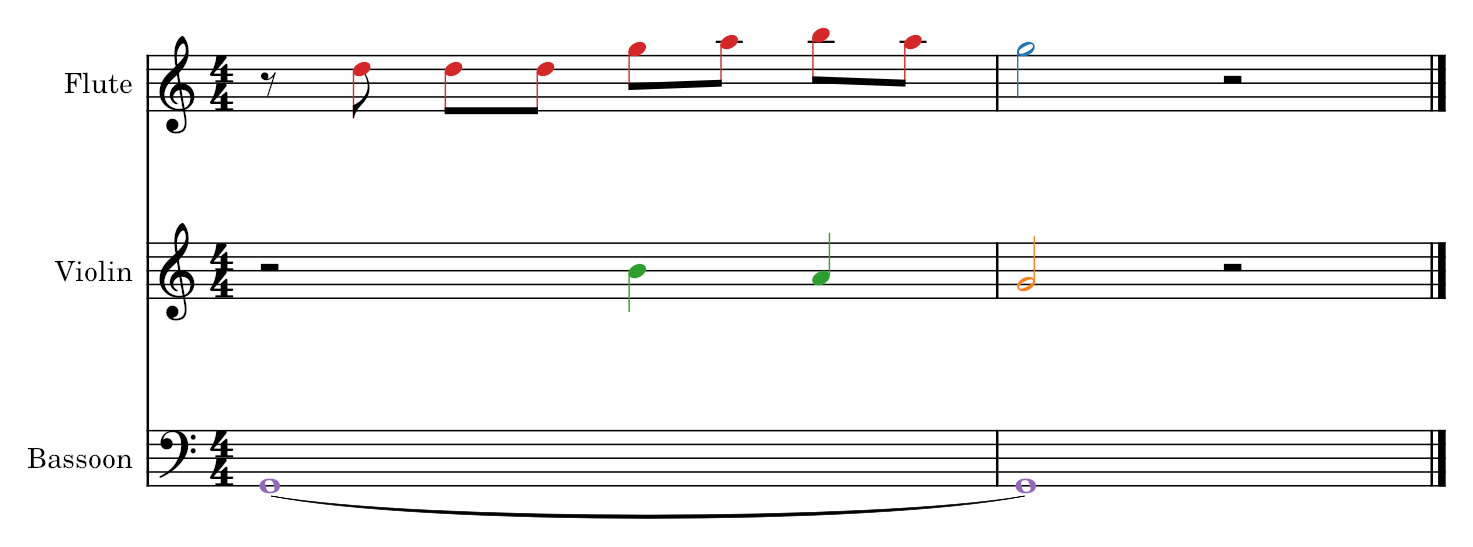

In [3]:
# Toy example score
f1 = T.RED.value
f2 = T.BLUE.value
v1 = T.GREEN.value
v2 = T.ORANGE.value
b1 = T.PURPLE.value

toy = stream.Score()

flute = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g'2 r")
for el in flute.flatten().getElementsByOffset(0.5,3.5):
    el.style.color = f1
for el in flute.flatten().getElementsByOffset(4,5):
    el.style.color = f2
flute.insert(0,instrument.Flute())
toy.insert(0,flute)

violin = converter.parse("tinyNotation: 4/4 r2 b4 a4 g2 r")
for el in violin.flatten().getElementsByOffset(2,3):
    el.style.color = v1
for el in violin.flatten().getElementsByOffset(4,5):
    el.style.color = v2
violin.insert(0,instrument.Violin())
toy.insert(0,violin)

bassoon = converter.parse("tinyNotation: 4/4 GG1~ GG1")
bassoon.insert(0,instrument.Bassoon())
for el in bassoon.flatten().notes:
    el.style.color = b1
toy.insert(0,bassoon)

toy.show(leaveMargin=50)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_trim.png", dpi=300)
#toy.write(fmt="musicxml.png", fp="../Figures/toy.png", dpi=300, leaveMargin=50)

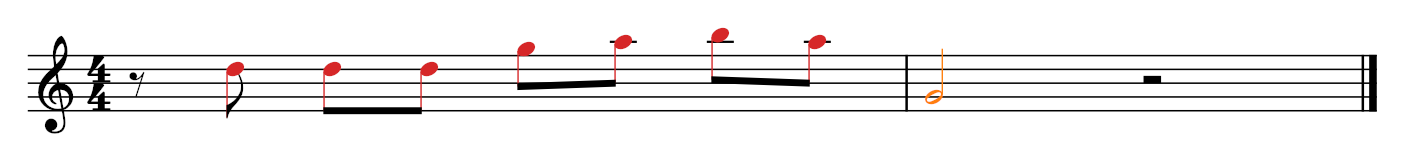

WindowsPath('c:/Users/Lucas/OneDrive - Durham University/PHYS4213/Figures/toy_arrangement-1.png')

In [ ]:
# Toy selected score
toy = stream.Score()

arrangement = converter.parse("tinyNotation: 4/4 r8 d' d' d' g' a' b' a' g2 r")
for el in arrangement.flatten().getElementsByOffset(0.5,3.5):
    el.style.color = f1
for el in arrangement.flatten().getElementsByOffset(4,5):
    el.style.color = v2
toy.insert(0,arrangement)

toy.show(leaveMargin=50)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_arrangement_trim.png", dpi=300)
#toy.write(fmt="musicxml.png", fp="../Figures/toy_arrangement.png", dpi=300, leaveMargin=50)

(np.float64(-1.209829125202103),
 np.float64(1.2082017461745111),
 np.float64(-0.7538426581005653),
 np.float64(0.7553152653763618))

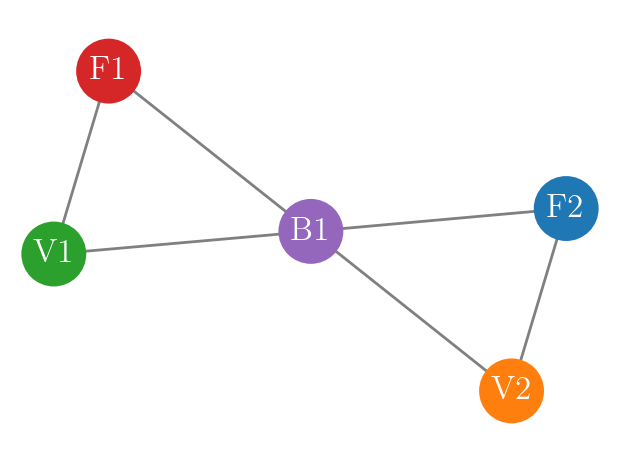

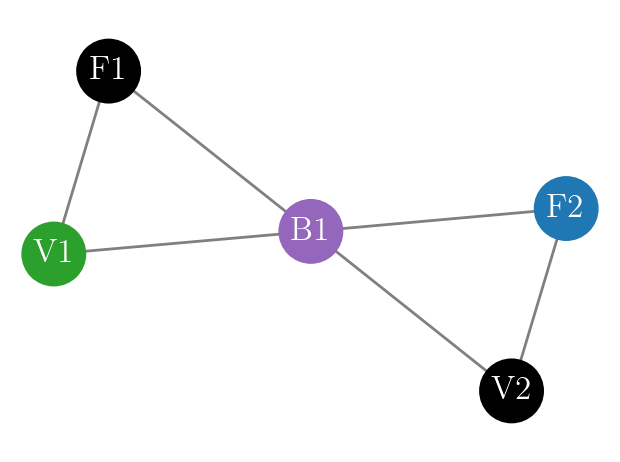

In [4]:
# Toy example graph

edges = [("F1","V1"), ("V1","B1"), ("F1","B1"), ("F2","V2"), ("V2","B1"), ("F2","B1")]

F = nx.Graph()
F.add_edges_from(edges)

colours = [f1, v1, b1, f2, v2]

pos = nx.spring_layout(F, seed=1)
plt.figure(0)
nx.draw_networkx(F, pos=pos, edge_color="gray", width=1, font_color="white", node_size=500, node_color=colours, hide_ticks=True)
plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
#plt.savefig("..\Figures\\toy_graph.svg")

plt.figure(1)
selected = ["F1", "V2"]
nx.draw_networkx(F, pos=pos, edge_color="gray", width=1, font_color="white", node_size=500, node_color=["black",v1,b1,f2,"black"], hide_ticks=True)
plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
#plt.savefig("..\Figures\\toy_solution.pgf")